In [1]:
from pyabc import History
from pyabc_custom import MyokitSimulation
import matplotlib.pyplot as plt
%matplotlib inline
%config Inline.Backend.figure_format = 'retina'

In [2]:
# Get all ABC channel results.
history = {'icat': History('sqlite:///pyabc-runs/hl-1_icat.db'),
           'ical': History('sqlite:///pyabc-runs/hl-1_ical.db'),
           'ina': History('sqlite:///pyabc-runs/hl-1_ina.db'),
           'ikr': History('sqlite:///pyabc-runs/hl-1_ikr.db'),
           'ikur': History('sqlite:///pyabc-runs/hl-1_ikur.db'),
           'ito': History('sqlite:///pyabc-runs/hl-1_ito.db'),
           'iha': History('sqlite:///pyabc-runs/hl-1_iha.db'),
           'ik1': History('sqlite:///pyabc-runs/hl-1_ik1.db')}

In [3]:
# Set to correct result (last ABC run in database).
for _,h in history.items():
    h.id = len(h.all_runs())

In [4]:
# Generate a sample from all history items.
def generate_sample(history, n):
    samples = [dict() for i in range(n)]
    for k, h in history.items():
        dist = h.get_distribution(m=0)
        weights = dist[1]
        ch_samples = dist[0] \
                    .sample(n, weights=weights, replace=True) \
                    .to_dict(orient='records')
        ch_samples = [{k+'.'+key: value for key, value in ch.items()}
                      for ch in ch_samples]
        for c, s in zip(ch_samples, samples):
            s.update(c)
    return samples

In [29]:
# Generate samples
n_samples = 15
param_samples = generate_sample(history, n_samples)

/storage/hhecm/cellrotor/chouston/miniconda3/envs/pyabc/lib/python3.6/site-packages/pyabc-0.8.21-py3.6.egg/pyabc/storage/history.py:200: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  w_arr = w.w.as_matrix()


In [39]:
# Manual settings
for sample in param_samples:
    sample['ik1.g_K1'] = 0.021 #0.024 produced appropriate levels for Ca_i and Na_i
    sample['incx.k_NCX'] = 5e-16#2.268e-16
    sample['icab.g_Cab'] = 0.0001#0.0008
    sample['inab.g_Nab'] = 0.005
    sample['inak.i_NaK_max'] = 4

## Plot sample of voltage traces

In [40]:
from pyabc_custom import simulate
import seaborn as sns
import numpy as np
import pandas as pd

output_samples = pd.DataFrame()
n_failures = 0
for i, sample in enumerate(param_samples):
    try:
        output = simulate('hl1', exp_num=0, **sample)
    except:
        n_failures = n_failures + 1
        continue
    output['sample'] = i
    output_samples = output_samples.append(output,
                                           ignore_index=True)
print('There were ' + str(n_failures) + ' failed simulations.')

There were 0 failed simulations.


/storage/hhecm/cellrotor/chouston/miniconda3/envs/pyabc/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Variable: membrane.V
Mean: -64.79374119999999
Standard Deviation: 9.003042360365539
Median: -67.167179
Interquartile range: 4.6748549999999796


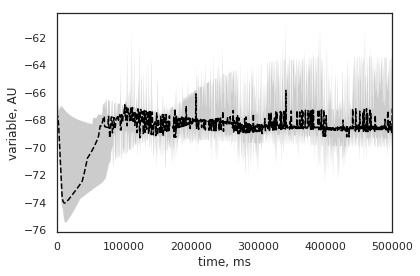

In [41]:
sns.set_context('notebook')
sns.set_style('white')

y_var = 'membrane.V'

grid = sns.tsplot(output_samples,
                  time="environment.time", value=y_var,
                  unit="sample", 
                  estimator=np.median, 
                  err_style="ci_band", ci=95,
                  color="black")
grid.set_xlabel('time, ms')
grid.set_ylabel('variable, AU')
for l in grid.axes.lines:
    l.set_linestyle('--')
plt.tight_layout()
#plt.savefig('pulse_train_Ca.pdf', format='pdf', dpi=1000)

final_time = max(output_samples['environment.time'])

print('Variable: ' + y_var)
men = np.mean(output_samples[output_samples['environment.time']==final_time][y_var])
print('Mean: ' + str(men))
sd = np.std(output_samples[output_samples['environment.time']==final_time][y_var])
print('Standard Deviation: ' + str(sd))
med = np.median(output_samples[output_samples['environment.time']==final_time][y_var])
print('Median: ' + str(med))
perc = np.percentile(output_samples[output_samples['environment.time']==final_time][y_var], [75,25])
print('Interquartile range: ' + str(perc[0]-perc[1]))